In [1]:
import os
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from shutil import copyfile

In [2]:
print(len(os.listdir('PetImages\Cat')))
print(len(os.listdir('PetImages\Dog')))

11749
11675


In [3]:
dir = "PetImages/"

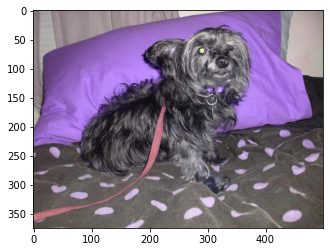

In [4]:
Categories = ['Dog', 'Cat']

for categories in Categories:
    path = os.path.join(dir, categories)
    for img in os.listdir(path):
        img_array1 = cv2.imread(os.path.join(path , img))
        plt.imshow(img_array1)
        plt.show()
        break
    break

In [5]:
img_array1.shape # Rgb

(375, 500, 3)

# Visualize our dataset

In [6]:
cat = os.path.join('PetImages/Cat/')
dog = os.path.join('PetImages/Dog/')
cat_names = os.listdir(cat)
dog_names = os.listdir(dog)

In [7]:
#parameters for our graph; we'll output images in a 4x4 configuration
nrows =4
ncols=4

#Index for iterating over images
pic_index= 0

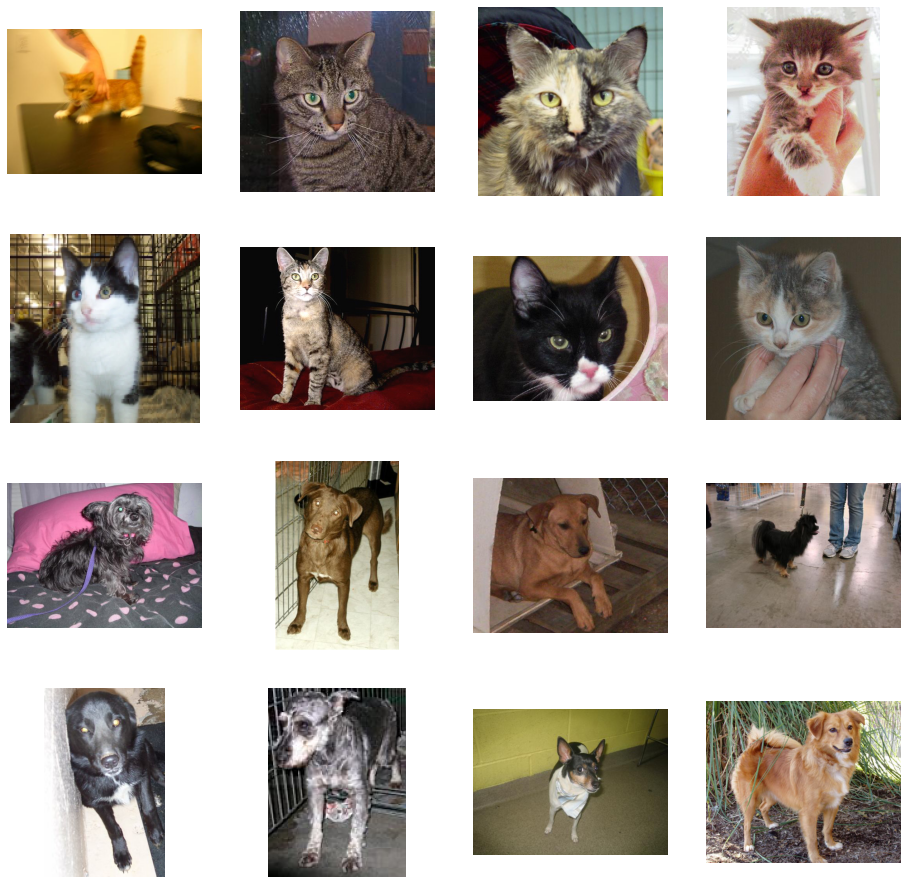

In [8]:
import matplotlib.image as mpimg
fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows *4)

pic_index += 8
next_cat_pix = [os.path.join(cat, fname)
               for fname in cat_names[pic_index-8:pic_index]]

next_dog_pix = [os.path.join(dog, fname)
               for fname in dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis("off")
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

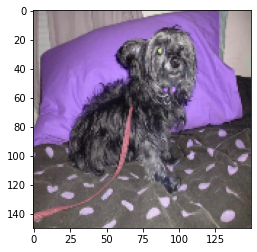

In [30]:
img_size = 150 #this size is good 

new_array = cv2.resize(img_array1, (img_size, img_size)) # for dogs
plt.imshow(new_array)
plt.show()

Deleate crroupted images

In [10]:
num_skipped = 0
for folder_name in Categories:
    folder_path = os.path.join(dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [11]:
print(len(os.listdir(cat)))# check for cat
print(len(os.listdir(dog))) #check for dog

11749
11675


Make validation data

In [12]:
try:
    os.mkdir('cats-v-dogs')
    os.mkdir('cats-v-dogs/training')
    os.mkdir('cats-v-dogs/testing')
    os.mkdir('cats-v-dogs/training/cats')
    os.mkdir('cats-v-dogs/training/dogs')
    os.mkdir('cats-v-dogs/testing/cats')
    os.mkdir('cats-v-dogs/testing/dogs')
except OSError:
    pass

Split Data in training and Validation<br>
Also check one more time is there any crroupted image or not

In [13]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "PetImages/Cat/"
TRAINING_CATS_DIR = "cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "cats-v-dogs/testing/cats/"

DOG_SOURCE_DIR = "PetImages/Dog/"
TRAINING_DOGS_DIR = "cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [14]:
print(len(os.listdir('cats-v-dogs/training/cats/')))
print(len(os.listdir('cats-v-dogs/training/dogs/')))

print(len(os.listdir('cats-v-dogs/testing/cats/')))
print(len(os.listdir('cats-v-dogs/testing/dogs/')))


10574
10507
1175
1168


After spliting we have imbalanced training data.<br>
First we have to balanced our training data.<br>
For balancing we use data augmentation and we use some new images for this process.

In [15]:
imgplot = mpimg.imread("dog.jpg")
imgplot

array([[[130, 116,  90],
        [132, 118,  92],
        [134, 120,  94],
        ...,
        [171, 166, 160],
        [169, 164, 160],
        [168, 163, 159]],

       [[131, 117,  91],
        [132, 118,  92],
        [134, 120,  94],
        ...,
        [171, 166, 160],
        [169, 164, 158],
        [168, 163, 159]],

       [[129, 117,  91],
        [131, 119,  93],
        [135, 121,  95],
        ...,
        [171, 166, 160],
        [169, 164, 158],
        [168, 163, 157]],

       ...,

       [[129, 104,  73],
        [130, 105,  74],
        [131, 106,  76],
        ...,
        [180, 163, 145],
        [180, 161, 144],
        [179, 160, 143]],

       [[125, 100,  69],
        [126, 101,  70],
        [127, 102,  72],
        ...,
        [182, 165, 147],
        [181, 162, 145],
        [181, 162, 145]],

       [[124,  99,  68],
        [124,  99,  68],
        [125, 100,  70],
        ...,
        [183, 166, 148],
        [182, 163, 146],
        [181, 162, 145]]

# Data Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

img = load_img("dog.jpg")  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='cats-v-dogs/training/dogs/', save_prefix='dog', save_format='jpeg'):
    i += 1
    if i > 60:
        break  # otherwise the generator would loop indefinitely


In [21]:
print(len(os.listdir('cats-v-dogs/training/cats/')))
print(len(os.listdir('cats-v-dogs/training/dogs/')))
# we balanced our training data 
# as you see i>60 but we run our data augmentation 5 to 6 times by changing values of parameters. 

10574
10574


**Until now**<br>
1:-We found that **(150,150) is the best image size for our image**.<br>
2:-We remove corrupted images.<br>
3:-Split our data into train and validation<br>
4:-Balanced our Imbalanced training dataset with the help of **Image Data Augmentation.**

In our next folder **(Base model)** work we doing.<br>

1:- Generate our data by using **ImageDataGenerator**.<br>
2:- Resacle and resize our data in **ImagedataGenerator**.<br>
3:- Built our **Model Base**.<br>

And other process.
